# **Table Of Contents**
1. Problem Statement and Research Question
2. Data Exploration and Visualization
3. Baseline Models (Majority Class, Linear Regression)
4. Interpreting Models and Results
5. Final Model Pipeline (Logistic Regression, kNN)

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Problem Statement and Research Question**

**Question:** Can New York Times headlines provide us with information that we can use to predict changes in the S&P 500?

**Description:** Using various sentiment analysis methods (VADER and TextBlob), we computed a score for each NYT headline (2.1 million). Each headline includes a date and section field as well. NYT headlines were collected from 1990 to 2020 (avoiding harder to predict post-COVID fluctuations in the market). Subsequent S&P 500 data closing prices have been collected at each time period during this timeframe, and we scaled these values to account for inflation.

**Approach:** To do this, we created a dataframe with an entry for each time point. For that time point, we average the sentiment scores for that day, and also add the number of headlines from each section into the row. Finally, our response is the S&P 500 closing price.

For the sentiment analysis, we used two different methods - VADER and TextBlob - to give a score to each NYT article headline. Due to the short nature of each headline (on average 6 words or less), the majority of scores are 0, thus we exclude sentiment scores of 0 in order to assess either a positive or negative value for the time period - we will experiment with this threshold. Finally, the timepoints we are testing will be day, week, month, and year. This means we have a df where each row is a day date (averaged sentiment scores for that day and S&P closing price for that day), week (averaged sentiment scores for that day and averaged S&P closing price for that week) and so on.

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>


# **Data Exploration and Visualization**

In our previous milestone 3, we created 4 dataframes each for 1 day, 1 week, 1 month, and 1 year time points. In the file, we also updated this code to separate our headlines into a train / test split of 15%. To do this, the 15% of headlines per day were randomly selected to create a day/week/month/year test df with all the same features as the train dfs. In total, we have 8 dataframes found in the **df_train_test** folder, each separated as described in the previous molestone file.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

### **File Description Post Cleaning**

1. __daily_test.xlsx & daily_train.xlsx__
    Average sentiment of the day's headlines, and number of headlines in each section for that date. Closing price for the day.
3. __weekly_test.xlsx & weekly_train.xlsx__
    Average sentiment of the week's headlines, and number of headlines in each section for that week. Average closing price for the week.
3. __monthly_test.xlsx & monthly_train.xlsx__
    Average sentiment of the months's headlines, and number of headlines in each section for that month. Average closing price for the month.
4. __yearly_test.xlsx & yearly_train.xlsx__
    Average sentiment of the year's headlines, and number of headlines in each section for that year. Average closing price for the year.

In [6]:
# Load in files from the folder which were saved from milestone 3 (train test split 15%)
daily_train = pd.read_excel("df_train_test/daily_train.xlsx", index_col=0)
weekly_train = pd.read_excel("df_train_test/weekly_train.xlsx", index_col=0)
monthly_train = pd.read_excel("df_train_test/monthly_train.xlsx", index_col=0)
yearly_train = pd.read_excel("df_train_test/yearly_train.xlsx", index_col=0)

daily_test = pd.read_excel("df_train_test/daily_test.xlsx", index_col=0)
weekly_test = pd.read_excel("df_train_test/weekly_test.xlsx", index_col=0)
monthly_test = pd.read_excel("df_train_test/monthly_test.xlsx", index_col=0)
yearly_test = pd.read_excel("df_train_test/yearly_test.xlsx", index_col=0)


We will scale all the computed values from -1 to 1 to best visualize our results. We will do this for VADER and TextBlob (both with and without zero values), percent change, and closing price.

In [7]:
# -1 to 1 scaling
def scale_column(data, column):
    min_val = data[column].min()
    max_val = data[column].max()
    data[f"{column}_scaled"] = 2 * (data[column] - min_val) / (max_val - min_val) - 1

datasets = [daily_train, daily_test, weekly_train, weekly_test, monthly_train, monthly_test, yearly_train, yearly_test]
columns_to_scale = [ "sentiment_score_VADER", "score_textblob", "sentiment_score_VADER_nonzero", "score_textblob_nonzero", "Inflation_Adjusted_Close", "Pct_Change" ]

for df in datasets:
    for col in columns_to_scale:
        if col in df.columns:
            scale_column(df, col)

In [8]:
# Just to check that all train files have same colums, and also to look at them.
daily_columns = set(daily_train.columns)
all_same_columns = (
    daily_columns == set(weekly_train.columns) ==
    set(monthly_train.columns) ==
    set(yearly_train.columns)
)

print("Columns in each of the dataframes shown below:")
display(daily_columns)
print("\nChecking that all the colums are consistent across the dataframes: ")
print(all_same_columns)

Columns in each of the dataframes shown below:


{'Admin',
 'Archives',
 'Arts',
 'At Home',
 'Automobiles',
 'Blogs',
 'Books',
 'Booming',
 'Briefing',
 'Burst',
 'Business Day',
 'Climate',
 'College',
 'Corrections',
 "Critic's Choice",
 'Crosswords & Games',
 'Editors Picks',
 'Education',
 'Fashion & Style',
 'Feeds',
 'Food',
 'Giving',
 'Global Home',
 'Great Homes & Destinations',
 'Guides',
 'Health',
 'Home & Garden',
 'Homepage',
 'Inflation_Adjusted_Close',
 'Inflation_Adjusted_Close_scaled',
 'International Home',
 'Job Market',
 'Lens',
 'Magazine',
 'Movies',
 'Multimedia/Photos',
 'NYT Now',
 'Neediest Cases',
 'New York',
 'Obituaries',
 'Open',
 'Opinion',
 'Parenting',
 'Pct_Change',
 'Pct_Change_scaled',
 'Podcasts',
 'Public Editor',
 'Reader Center',
 'Real Estate',
 'Science',
 'Slideshows',
 'Smarter Living',
 'Sports',
 'Style',
 'Sunday Review',
 'T Brand',
 'T Magazine',
 'Technology',
 'The Learning Network',
 'The Upshot',
 'The Weekly',
 'Theater',
 'Times Insider',
 'Times Topics',
 'Today’s Paper',
 '


Checking that all the colums are consistent across the dataframes: 
True


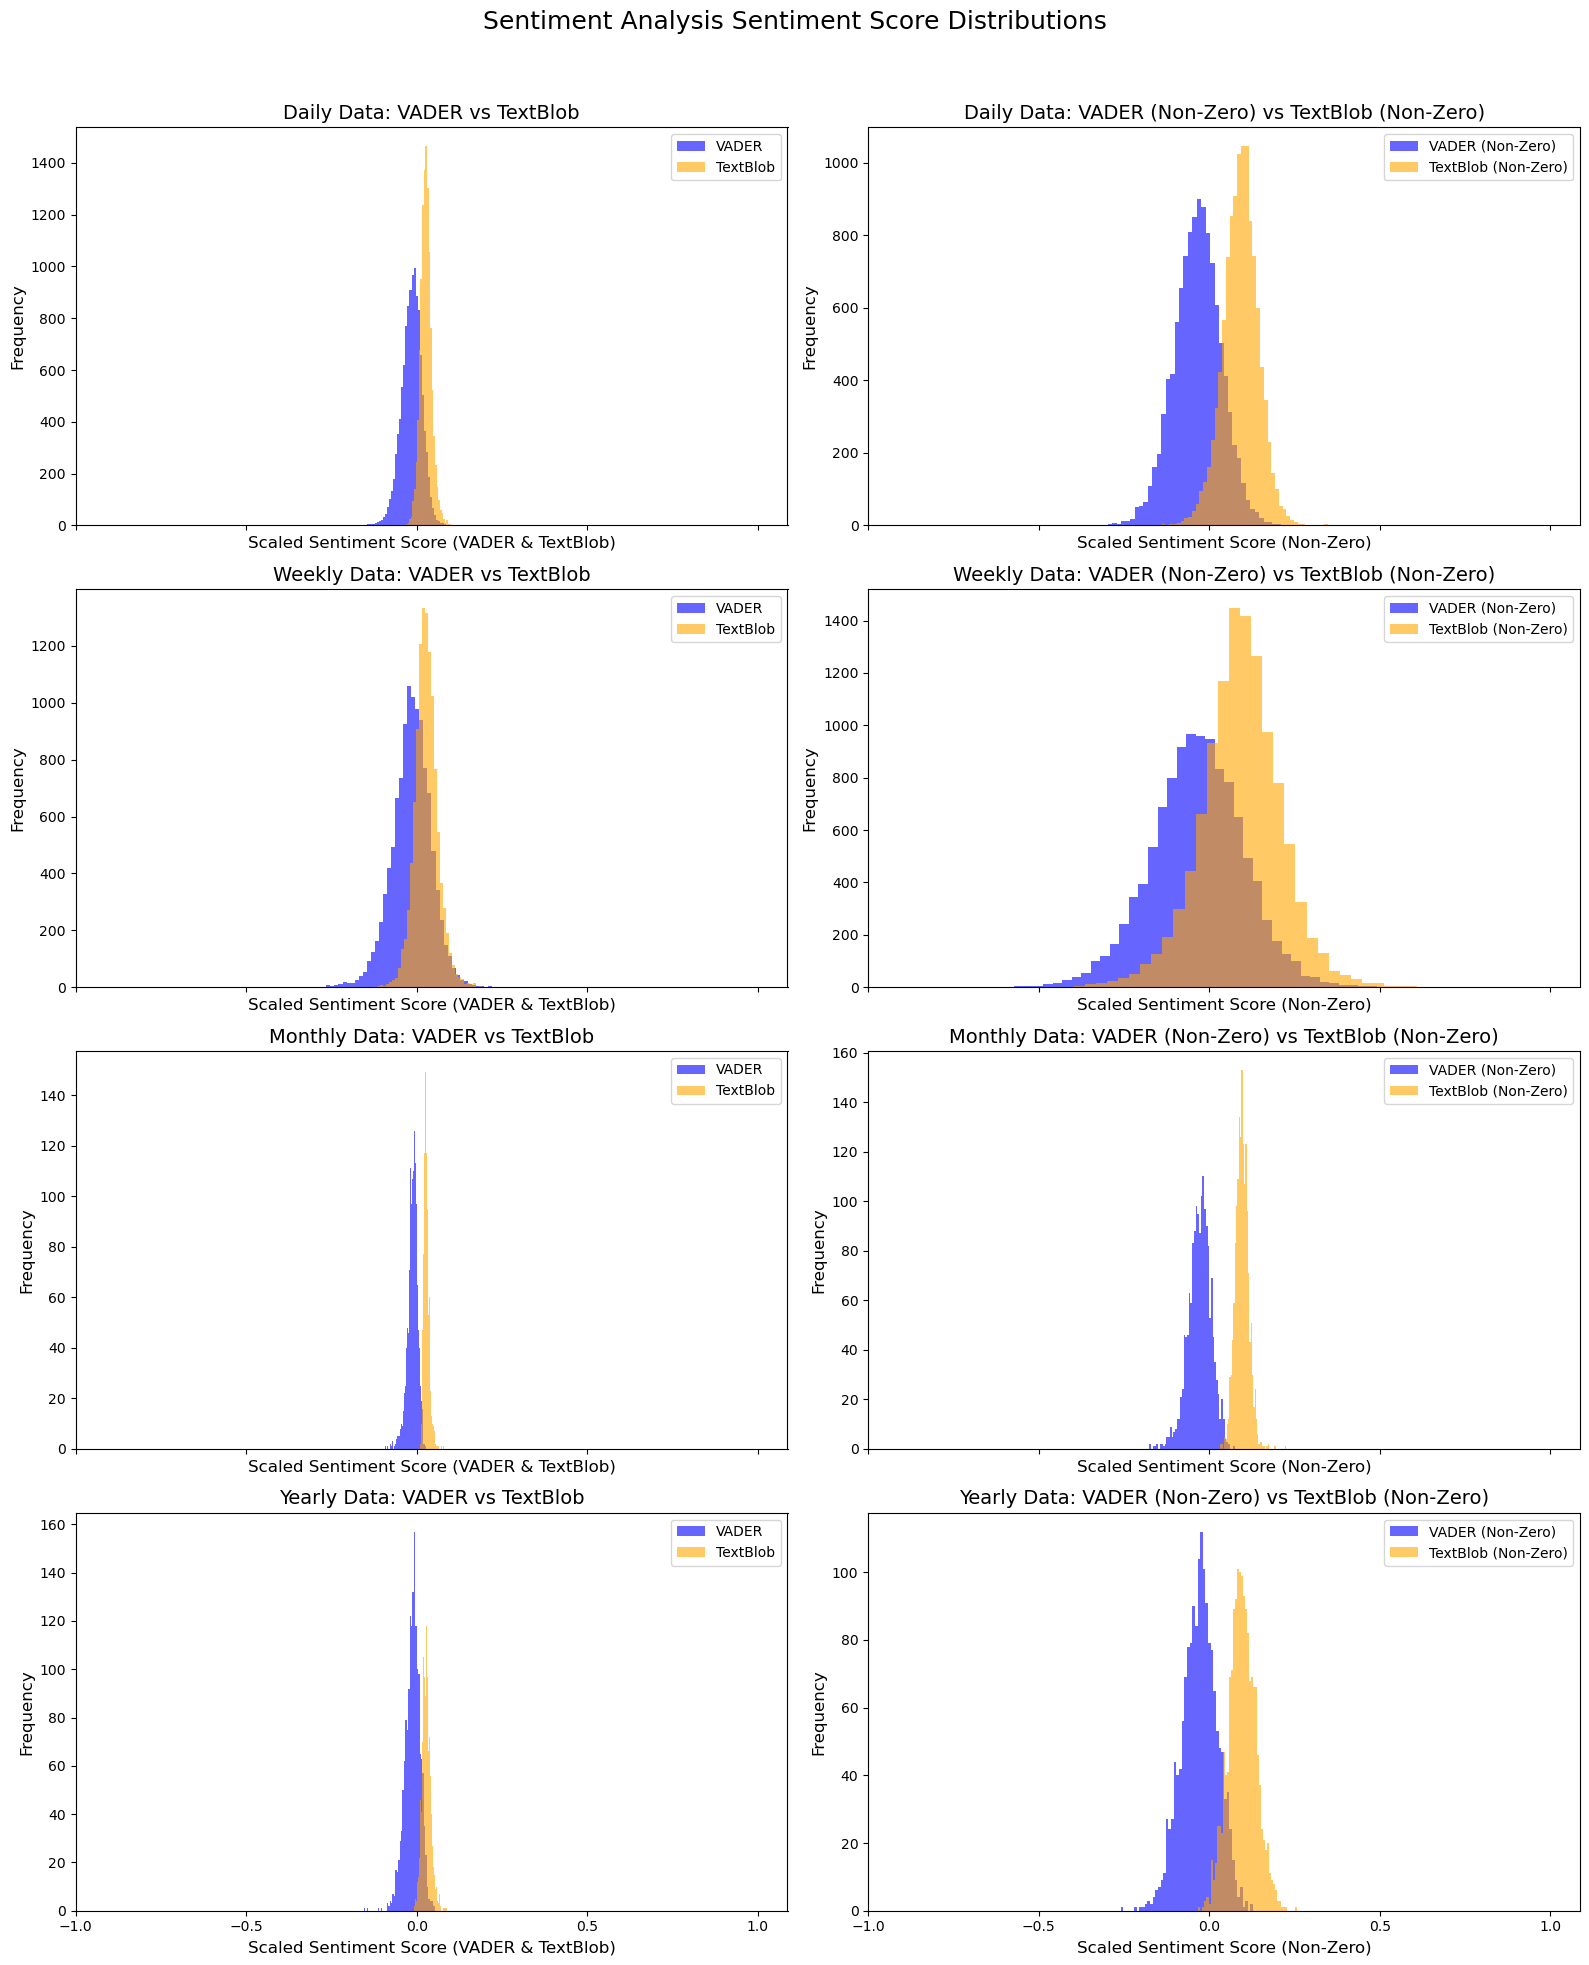

In [9]:
def plot_sentiment_distributions(datasets, title_prefix):
    fig, axes = plt.subplots(4, 2, figsize=(16, 20), sharex=True, sharey=False)
    fig.suptitle(f"{title_prefix} Sentiment Score Distributions", fontsize=18)

    freqs = ["Daily", "Weekly", "Monthly", "Yearly"]

    for i, (freq, df) in enumerate(zip(freqs, datasets)):
        # Plot VADER and TextBlob
        axes[i, 0].hist(df['sentiment_score_VADER'], bins=50, alpha=0.6, label='VADER', color='blue')
        axes[i, 0].hist(df['score_textblob'], bins=50, alpha=0.6, label='TextBlob', color='orange')
        axes[i, 0].set_title(f"{freq} Data: VADER vs TextBlob", fontsize=14)
        axes[i, 0].set_xlabel('Scaled Sentiment Score (VADER & TextBlob)', fontsize=12)
        axes[i, 0].set_ylabel('Frequency', fontsize=12)
        axes[i, 0].legend()
        axes[i, 0].set_xticks([-1, -0.5, 0, 0.5, 1])  # Add x-tick values
        axes[i, 0].tick_params(axis='x', labelsize=10)  # Adjust x-tick label size

        # Plot VADER (Non-Zero) and TextBlob (Non-Zero)
        axes[i, 1].hist(df['sentiment_score_VADER_nonzero'], bins=50, alpha=0.6, label='VADER (Non-Zero)', color='blue')
        axes[i, 1].hist(df['score_textblob_nonzero'], bins=50, alpha=0.6, label='TextBlob (Non-Zero)', color='orange')
        axes[i, 1].set_title(f"{freq} Data: VADER (Non-Zero) vs TextBlob (Non-Zero)", fontsize=14)
        axes[i, 1].set_xlabel('Scaled Sentiment Score (Non-Zero)', fontsize=12)
        axes[i, 1].set_ylabel('Frequency', fontsize=12)
        axes[i, 1].legend()
        axes[i, 1].set_xticks([-1, -0.5, 0, 0.5, 1]) 
        axes[i, 1].tick_params(axis='x', labelsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_sentiment_distributions(datasets, "Sentiment Analysis")


TODO: **NOTE DESCRIBE AND NOT SCALING - NON ZERO = MORE dialy var

Now, we can do EDA to explore the best time frame (D, W, M, Y) and also analyze and sentiment analysis method might be best. To do this, let's make a plot of all the different combinations of Sentiment analysis vs. Closing Price and Sentiment analysis vs. Percent Change.

In [10]:
def plot_sentiment_subplots(data_dict, sentiment_column, close_column, title_prefix, nonzero=False):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)
    fig.suptitle(f"{title_prefix} Sentiment vs. Normalized Closing Price", fontsize=16)

    for ax, (freq, data) in zip(axes.flat, data_dict.items()):
        filtered_data = data if not nonzero else data[data[sentiment_column] != 0]

        years = filtered_data.index.year
        cmap = cm.get_cmap("viridis")
        norm = plt.Normalize(years.min(), years.max())
        colors = cmap(norm(years))

        ax.scatter(filtered_data[sentiment_column], filtered_data[close_column], c=colors, alpha=0.6)
        ax.set_title(f"{freq.capitalize()} Data", fontsize=14)
        ax.set_xlabel(sentiment_column, fontsize=12)
        ax.set_ylabel(close_column, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

def plot_sentiment_vs_pct_change(data_dict, sentiment_column, pct_column, title_prefix, nonzero=False):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)
    fig.suptitle(f"{title_prefix} Sentiment vs. Percent Change", fontsize=16)

    for ax, (freq, data) in zip(axes.flat, data_dict.items()):
        filtered_data = data if not nonzero else data[data[sentiment_column] != 0]

        years = filtered_data.index.year
        cmap = cm.get_cmap("viridis")
        norm = plt.Normalize(years.min(), years.max())
        colors = cmap(norm(years))

        ax.scatter(filtered_data[sentiment_column], filtered_data[pct_column], c=colors, alpha=0.6)
        ax.set_title(f"{freq.capitalize()} Data", fontsize=14)
        ax.set_xlabel(sentiment_column, fontsize=12)
        ax.set_ylabel(pct_column, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

data_dict = {"Daily": daily_train, "Weekly": weekly_train, "Monthly": monthly_train, "Yearly": yearly_train}


### **Sentiment Score (Both VADER and TextBlob) vs. Closing Price and Percent Change**

/var/folders/dr/t680yxy14sg86lyy7xx7h41c0000gn/T/ipykernel_91916/1332258256.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


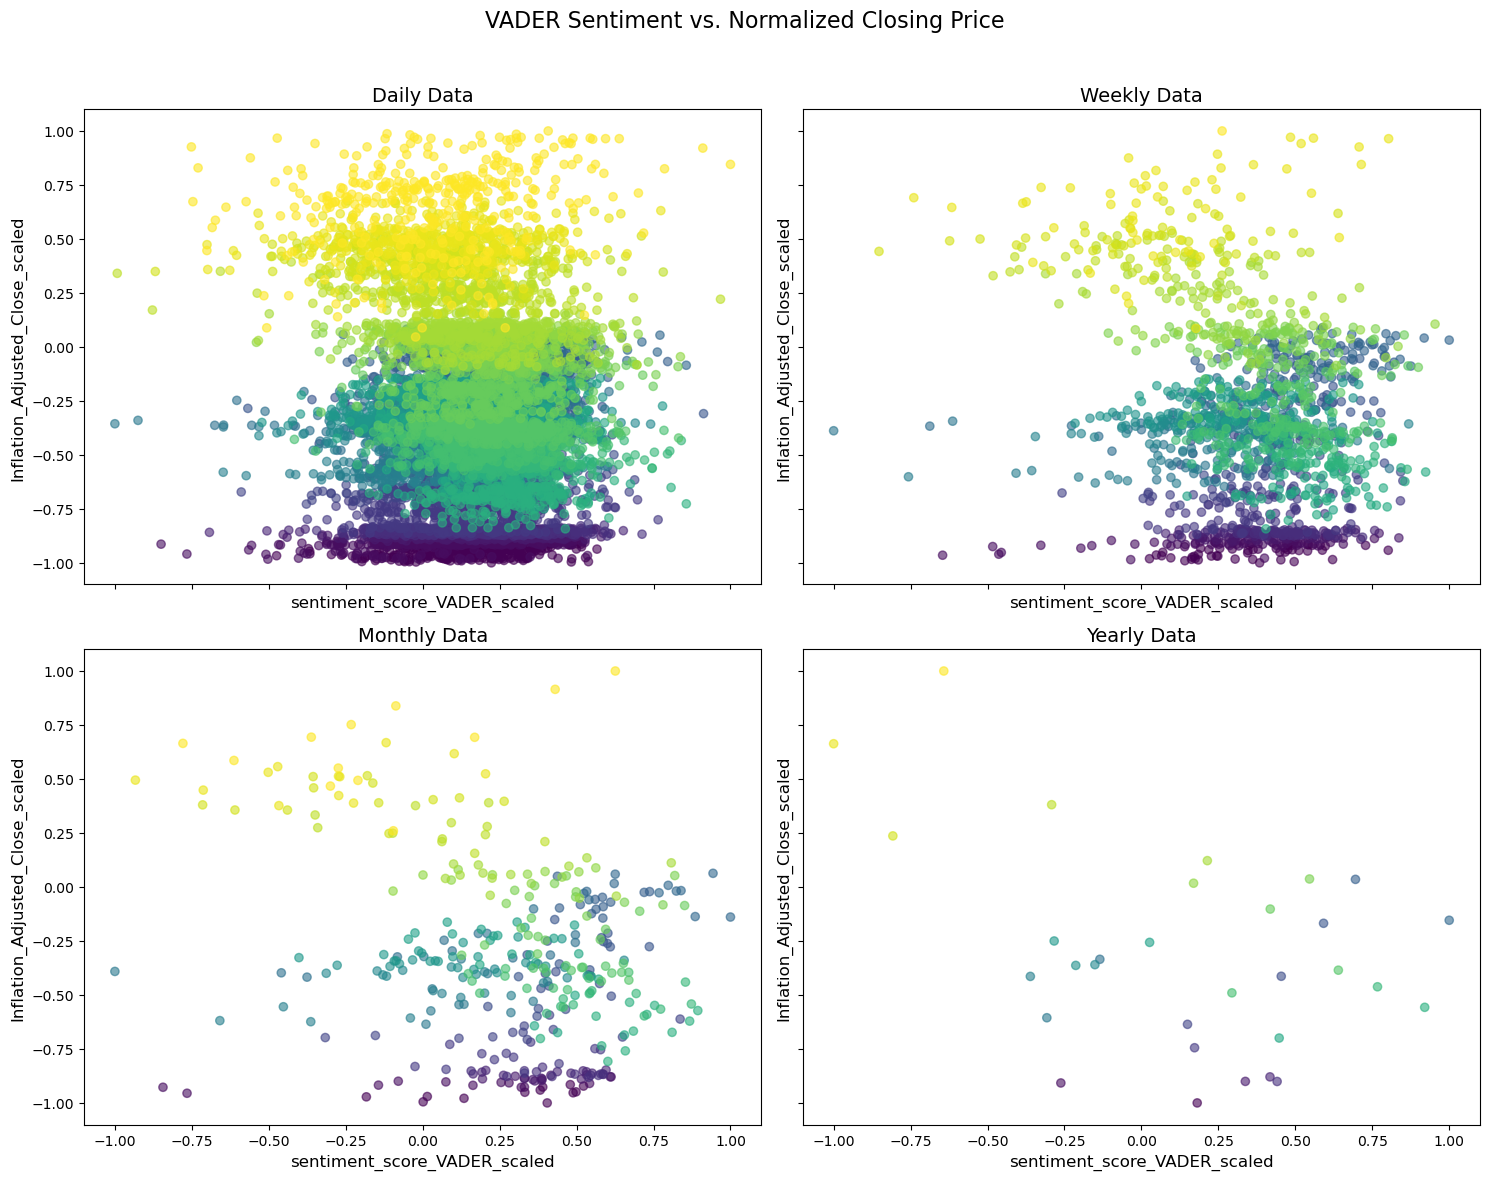

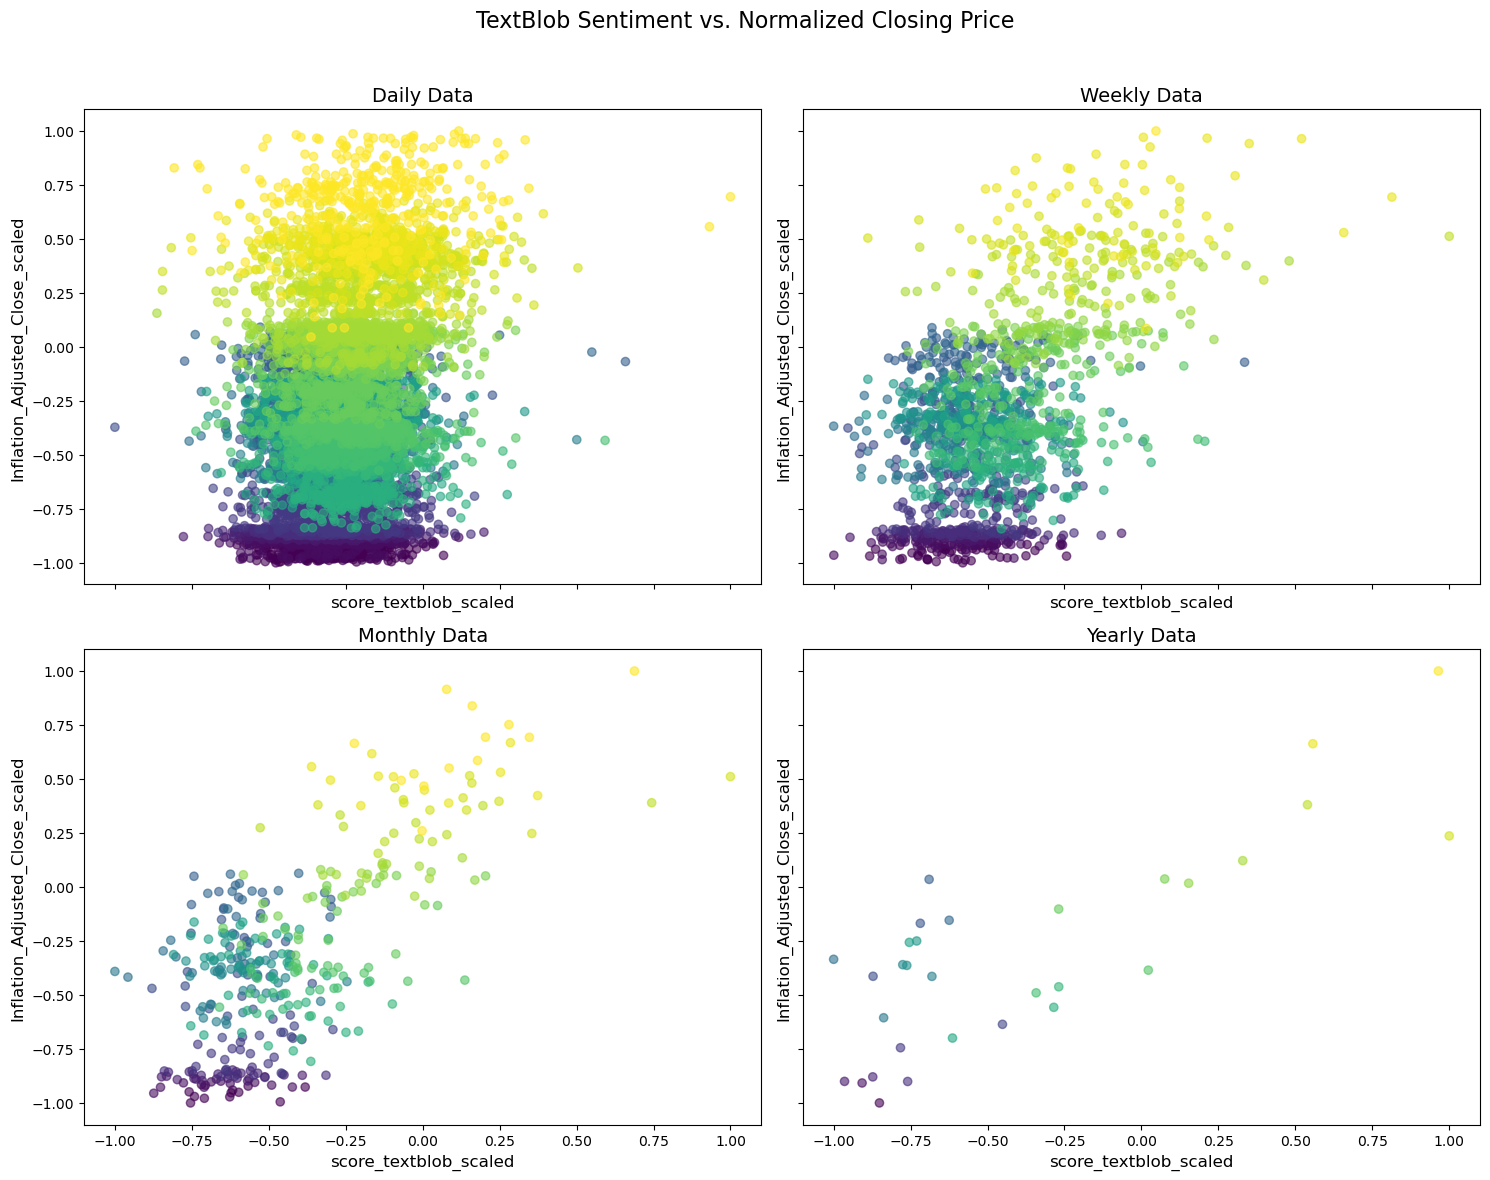

/var/folders/dr/t680yxy14sg86lyy7xx7h41c0000gn/T/ipykernel_91916/1332258256.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


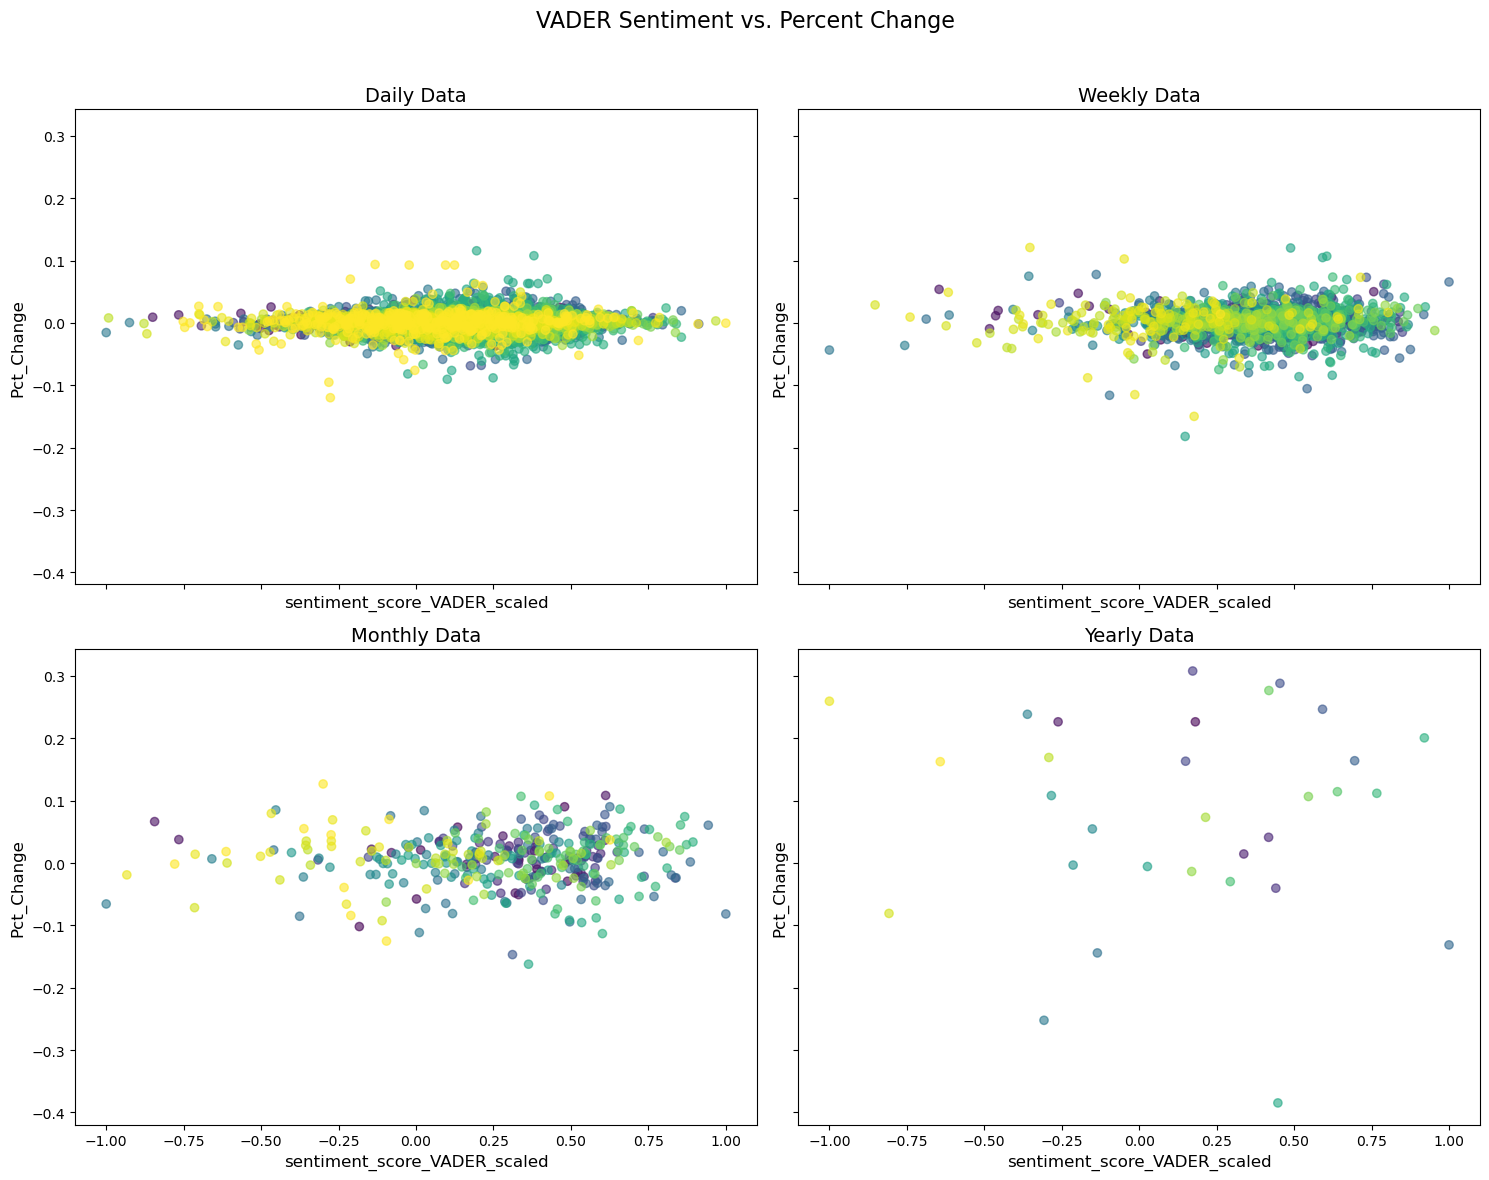

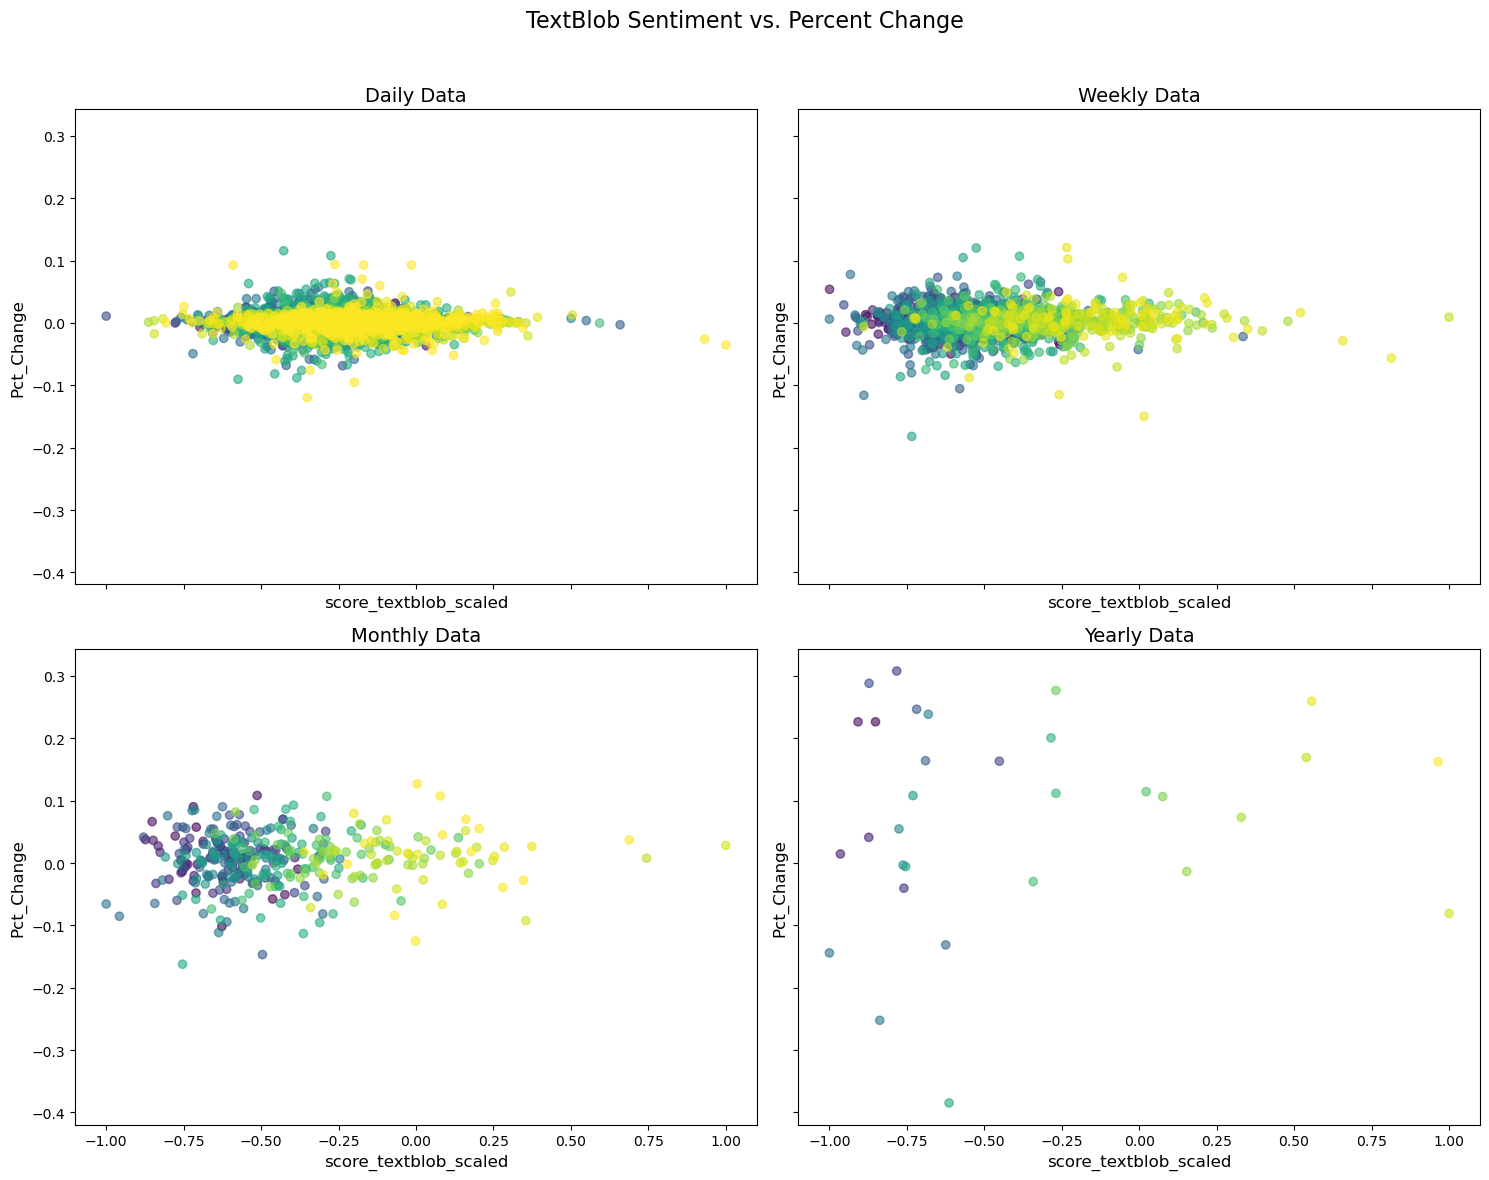

In [11]:
plot_sentiment_subplots(data_dict, 'sentiment_score_VADER_scaled', 'Inflation_Adjusted_Close_scaled', "VADER", nonzero=False)
plot_sentiment_subplots(data_dict, 'score_textblob_scaled', 'Inflation_Adjusted_Close_scaled', "TextBlob", nonzero=False)

plot_sentiment_vs_pct_change(data_dict, 'sentiment_score_VADER_scaled', 'Pct_Change', "VADER", nonzero=False)
plot_sentiment_vs_pct_change(data_dict, 'score_textblob_scaled', 'Pct_Change', "TextBlob", nonzero=False)

### **Sentiment Score (Both VADER and TextBlob excluding nonzero scores) vs. Closing Price and Percent Change**

/var/folders/dr/t680yxy14sg86lyy7xx7h41c0000gn/T/ipykernel_91916/1332258256.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


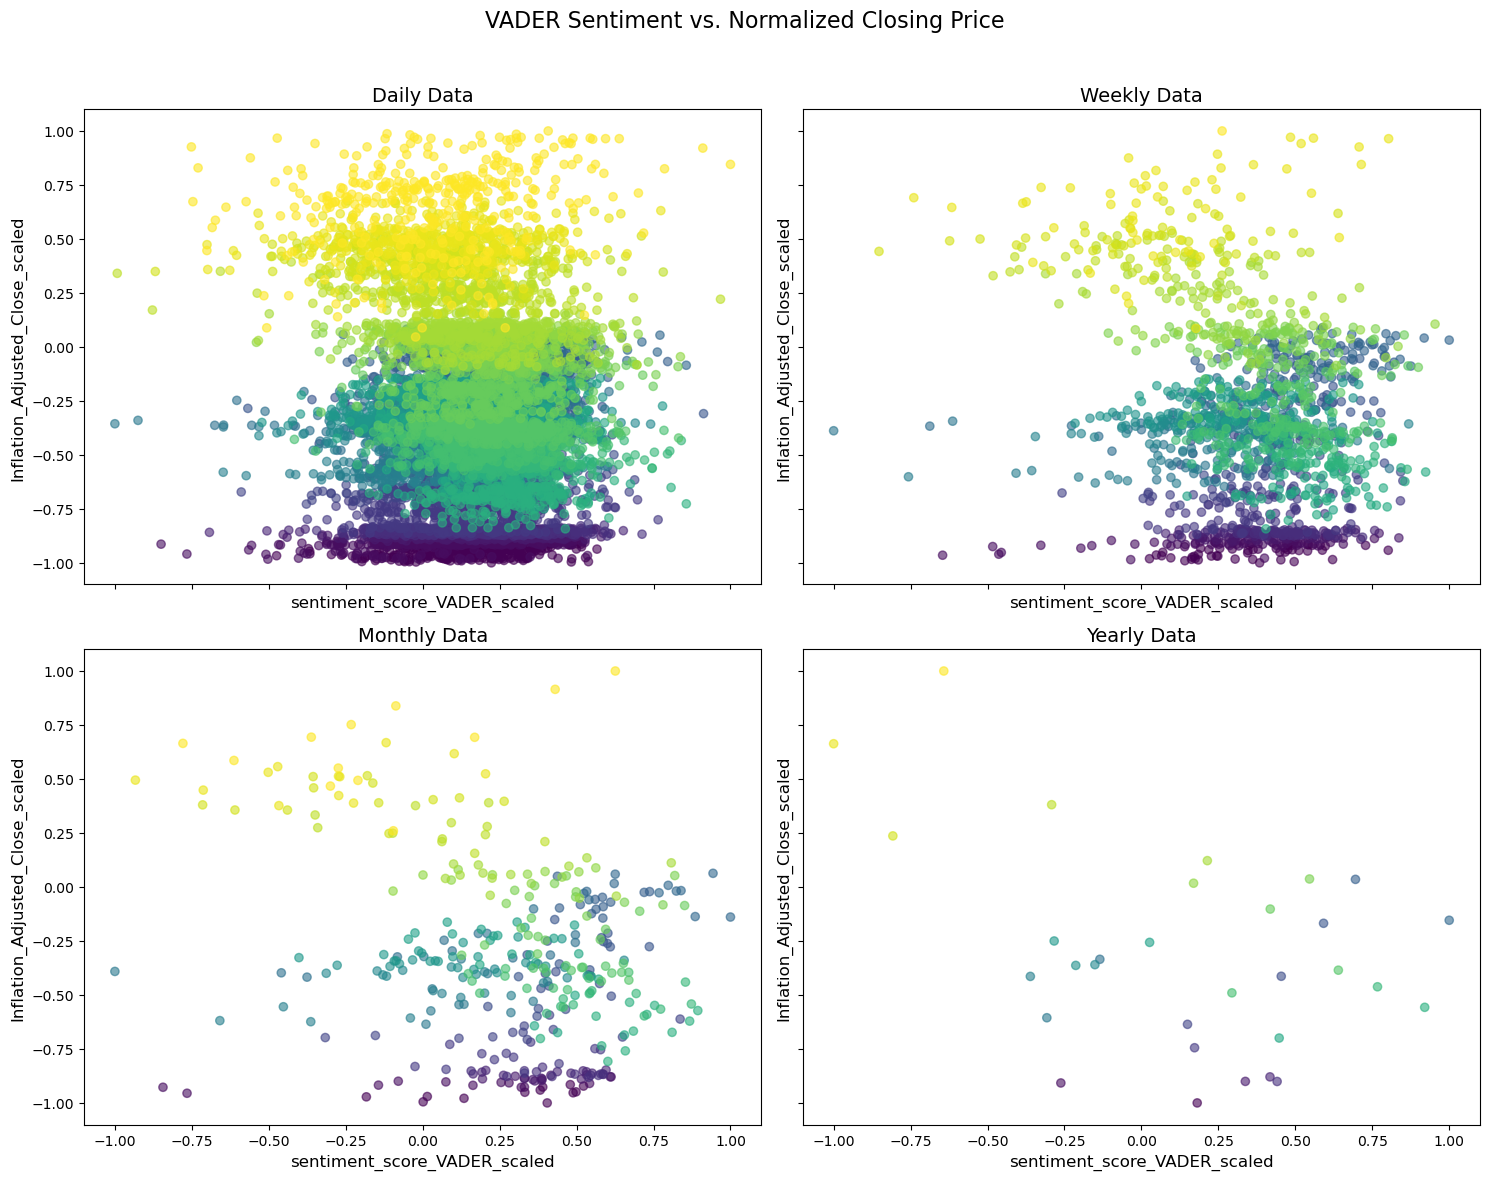

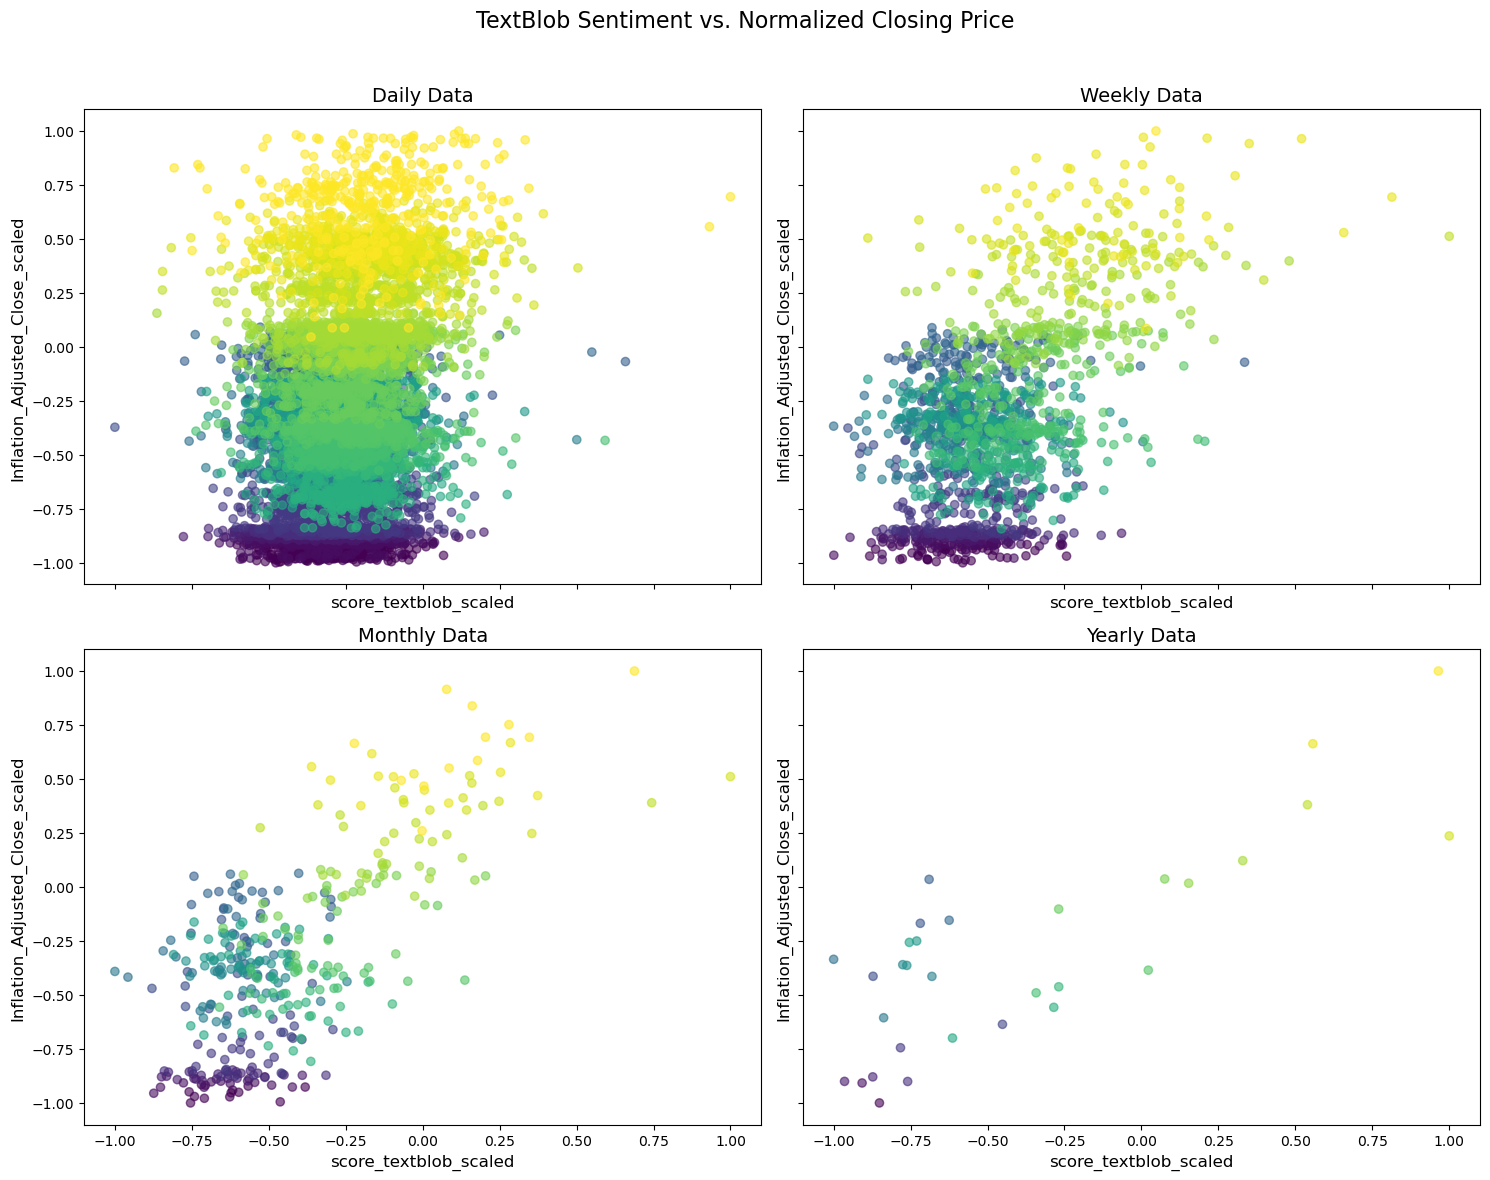

/var/folders/dr/t680yxy14sg86lyy7xx7h41c0000gn/T/ipykernel_91916/1332258256.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


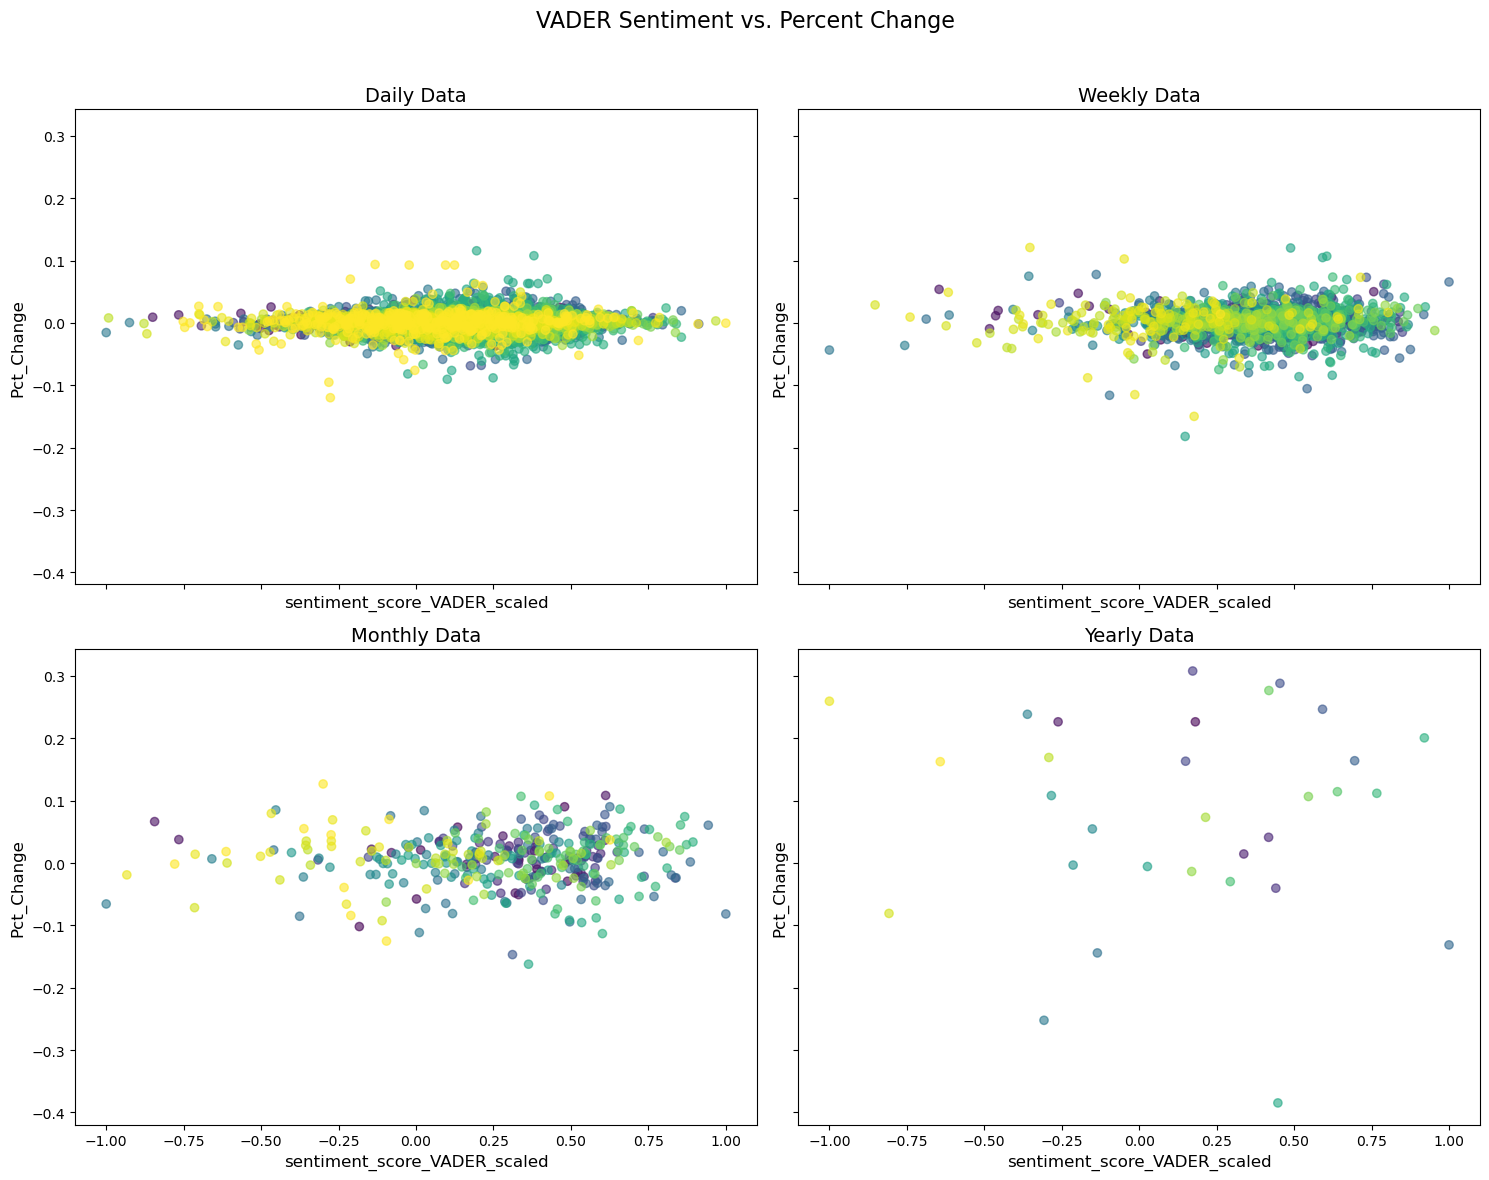

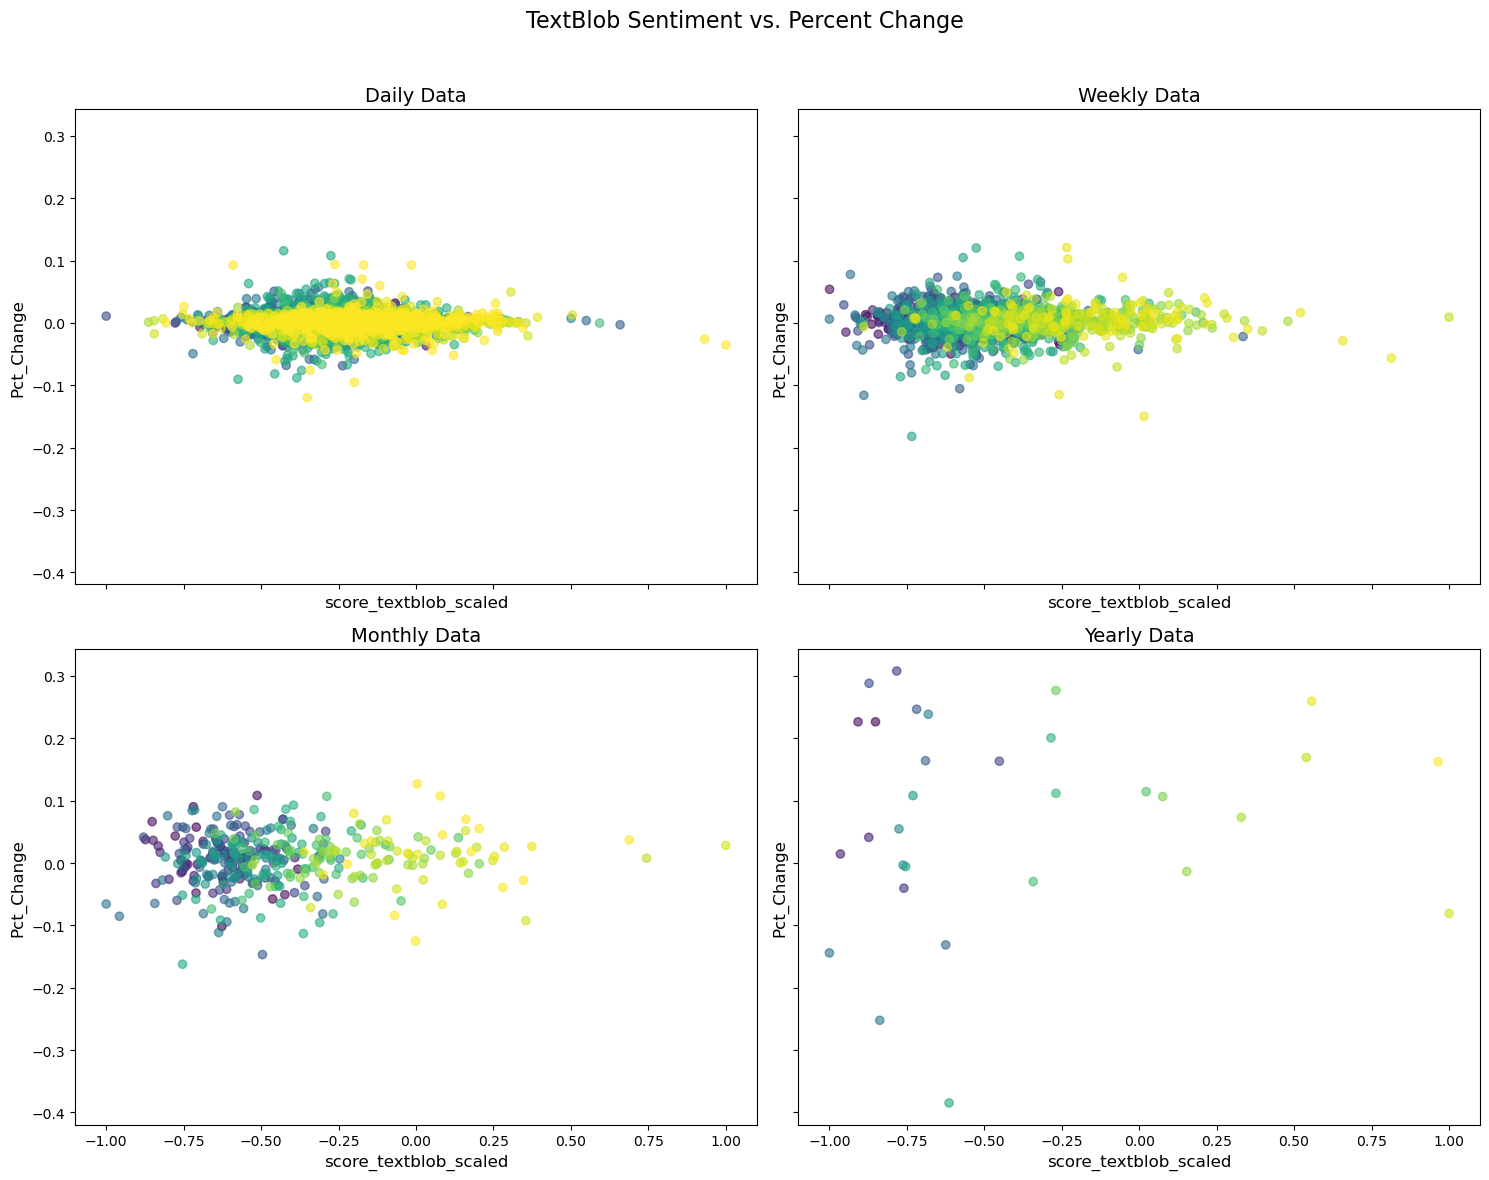

In [12]:
plot_sentiment_subplots(data_dict, 'sentiment_score_VADER_scaled', 'Inflation_Adjusted_Close_scaled', "VADER", nonzero=True)
plot_sentiment_subplots(data_dict, 'score_textblob_scaled', 'Inflation_Adjusted_Close_scaled', "TextBlob", nonzero=True)

plot_sentiment_vs_pct_change(data_dict, 'sentiment_score_VADER_scaled', 'Pct_Change', "VADER", nonzero=True)
plot_sentiment_vs_pct_change(data_dict, 'score_textblob_scaled', 'Pct_Change', "TextBlob", nonzero=True)

TODO: **EDA analysis:** It appears that 

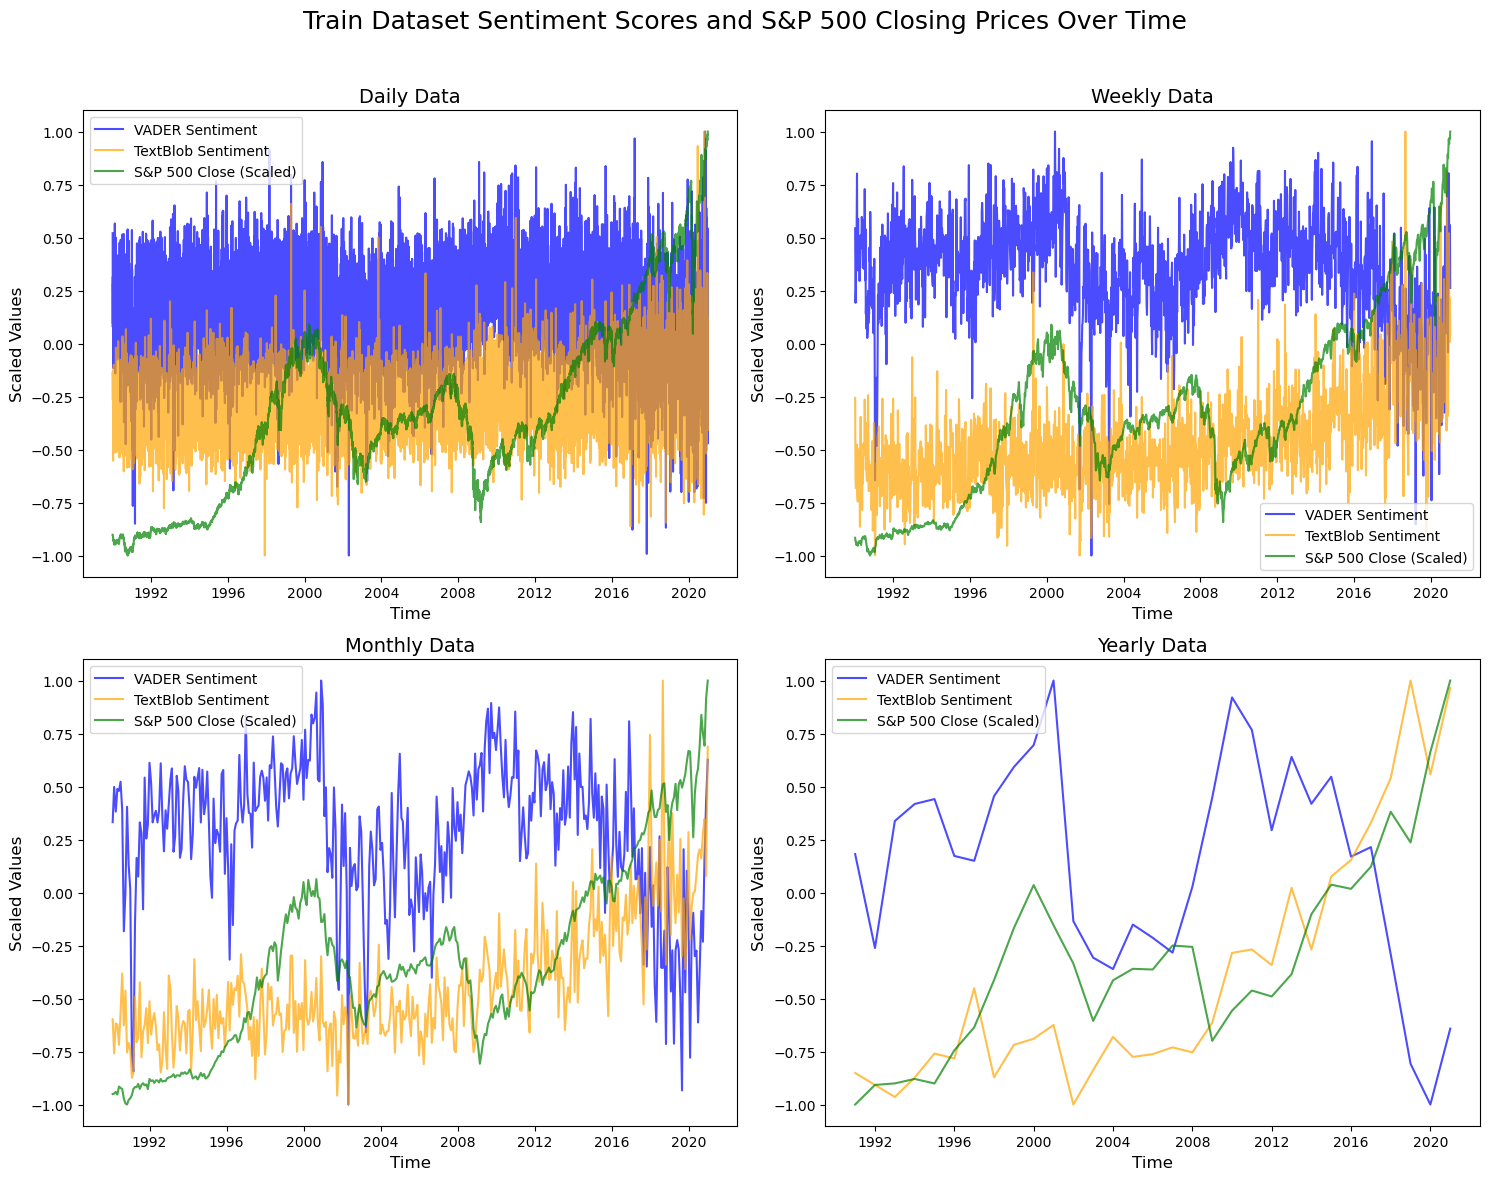

In [13]:
def plot_sentiment_and_sp500_over_time(datasets, title_prefix):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=False, sharey=False)
    fig.suptitle(f"{title_prefix} Sentiment Scores and S&P 500 Closing Prices Over Time", fontsize=18)

    freqs = ["Daily", "Weekly", "Monthly", "Yearly"]
    for ax, (freq, df) in zip(axes.flat, zip(freqs, datasets)):
        ax.plot(df.index, df['sentiment_score_VADER_scaled'], label='VADER Sentiment', color='blue', alpha=0.7)
        ax.plot(df.index, df['score_textblob_scaled'], label='TextBlob Sentiment', color='orange', alpha=0.7)

        ax.plot(df.index, df['Inflation_Adjusted_Close_scaled'], label='S&P 500 Close (Scaled)', color='green', alpha=0.7)

        ax.set_title(f"{freq} Data", fontsize=14)
        ax.set_xlabel('Time', fontsize=12)
        ax.set_ylabel('Scaled Values', fontsize=12)
        ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_sentiment_and_sp500_over_time(
    [daily_train, weekly_train, monthly_train, yearly_train],
    "Train Dataset"
)

TODO: **DISCUSS TIME TEXTBLOB INCREASE BUT ALSO S&P**

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>


# **Baseline Models**

Our model will predict the increase or decrease in the S&P closing price using the NYT headline sentiment scores as either a classification or regression problem. For the classification baseline model, we will use the majority class predictor. For the regression baseline model, we will use linear regression.

In [14]:
# Import libraries for modeling
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, \
                            classification_report, mean_squared_error, r2_score

## **Majority Class**

Our baseline model for the classification problem uses majority class prediction. First, we add an additional column that dictates whether the closing price for that month will increase or decrease.

In [15]:
def add_price_change_target(df):
    df['Price_Change_Target'] = (df['Inflation_Adjusted_Close'].shift(-1) > df['Inflation_Adjusted_Close']).astype(int)
    df = df[:-1] # drop last row, don't have that data
    return df

In [16]:
monthly_train = add_price_change_target(monthly_train)
monthly_test = add_price_change_target(monthly_test)

In [17]:
monthly_train.head()

sentiment_score_VADER  score_textblob  \
pub_date                                            
1990-01-31              -0.010442        0.024607   
1990-02-28              -0.004598        0.021047   
1990-03-31              -0.008690        0.024171   
1990-04-30              -0.004930        0.024061   
1990-05-31              -0.005256        0.021933   

            sentiment_score_VADER_nonzero  score_textblob_nonzero  \
pub_date                                                            
1990-01-31                      -0.030126                0.101515   
1990-02-28                      -0.013792                0.094326   
1990-03-31                      -0.025118                0.102296   
1990-04-30                      -0.015036                0.103977   
1990-05-31                      -0.016141                0.094616   

            Inflation_Adjusted_Close  Pct_Change  Admin  Archives  Arts  \
pub_date                                                                  
1990-01-31                329.079987    0.004599      0        10   351   
1990-02-28                330.593569    0.004599      0         6   345   
1990-03-31                337.032273    0.019476      0         8   409   
1990-04-30                327.207125   -0.029152      0        13   391   
1990-05-31                356.753109    0.090297      0         6   389   

            At Home  ...  timesselect  timestalks  xword  \
pub_date             ...                                   
1990-01-31        0  ...            0           0      0   
1990-02-28        0  ...            0           0      0   
1990-03-31        0  ...            0           0      0   
1990-04-30        0  ...            0           0      0   
1990-05-31        0  ...            0           0      0   

            sentiment_score_VADER_scaled  score_textblob_scaled  \
pub_date                                                          
1990-01-31                      0.332003              -0.597591   
1990-02-28                      0.498293              -0.758746   
1990-03-31                      0.381847              -0.617323   
1990-04-30                      0.488836              -0.622330   
1990-05-31                      0.479573              -0.718654   

            sentiment_score_VADER_nonzero_scaled  \
pub_date                                           
1990-01-31                              0.202027   
1990-02-28                              0.399835   
1990-03-31                              0.262677   
1990-04-30                              0.384772   
1990-05-31                              0.371385   

            score_textblob_nonzero_scaled  Inflation_Adjusted_Close_scaled  \
pub_date                                                                     
1990-01-31                      -0.192272                        -0.950644   
1990-02-28                      -0.341217                        -0.948705   
1990-03-31                      -0.176086                        -0.940456   
1990-04-30                      -0.141255                        -0.953043   
1990-05-31                      -0.335218                        -0.915191   

            Pct_Change_scaled  Price_Change_Target  
pub_date                                            
1990-01-31           0.154207                    1  
1990-02-28           0.154207                    1  
1990-03-31           0.257137                    0  
1990-04-30          -0.079314                    1  
1990-05-31           0.747140                    0  

[5 rows x 95 columns]

In [18]:
predictors = [
    'score_textblob',
    'score_textblob_nonzero',
    'score_textblob_nonzero_scaled',
    'score_textblob_scaled',
    'sentiment_score_VADER',
    'sentiment_score_VADER_nonzero',
    'sentiment_score_VADER_nonzero_scaled',
    'sentiment_score_VADER_scaled',
]

In [19]:
X_train, y_train_class = monthly_train[predictors], monthly_train['Price_Change_Target']
X_test, y_test_class = monthly_train[predictors], monthly_test['Price_Change_Target']

In [20]:
majority_class = y_train_class.mode()[0]
y_pred_majority = [majority_class] * len(y_test_class)
accuracy_majority = accuracy_score(y_test_class, y_pred_majority)

In [21]:
print("Accuracy of Majority Class Predictor:", accuracy_majority)

Accuracy of Majority Class Predictor: 0.6091644204851752


## **Linear Regression**

Our baseline model for the regression problem uses linear regression. For this section, we tested the basic linear regression model, as well as Ridge and LASSO.

In [22]:
y_train_reg = monthly_train['Inflation_Adjusted_Close']
y_test_reg = monthly_test['Inflation_Adjusted_Close']

#### **Basic Linear Regression**

In [23]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train_reg)
y_pred_linreg = lin_reg.predict(X_train)

In [24]:
mse_linreg = mean_squared_error(y_train_reg, y_pred_linreg)
r2_linreg = r2_score(y_train_reg, y_pred_linreg)

print("Mean Squared Error (MSE):", mean_squared_error(y_train_reg, y_pred_linreg))
print("R-squared:", r2_linreg)

Mean Squared Error (MSE): 38686.249396612715
R-squared: 0.6325677529932004


In [25]:
coeffs_linreg = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lin_reg.coef_
})

display(coeffs_linreg)

Feature  Coefficient
0                        score_textblob    17.967732
1                score_textblob_nonzero   -20.977042
2         score_textblob_nonzero_scaled  -434.662426
3                 score_textblob_scaled   813.443360
4                 sentiment_score_VADER   -59.380977
5         sentiment_score_VADER_nonzero   138.889067
6  sentiment_score_VADER_nonzero_scaled  1681.912666
7          sentiment_score_VADER_scaled -1689.627354

#### **Ridge Regression**

In [26]:
ridge_reg = Ridge()

param_grid = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(ridge_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train_reg)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100, 1000]},
             scoring='neg_mean_squared_error')

In [27]:
best_ridge_model = grid_search.best_estimator_
y_pred_ridge = best_ridge_model.predict(X_train)

# evaluate
mse_ridge = mean_squared_error(y_train_reg, y_pred_ridge)
r2_ridge = r2_score(y_train_reg, y_pred_ridge)

print("Best alpha:", grid_search.best_params_['alpha'])
print("Mean Squared Error (MSE) for Ridge:", mse_ridge)
print("R-squared for Ridge:", r2_ridge)

Best alpha: 0.01
Mean Squared Error (MSE) for Ridge: 38690.54895509963
R-squared for Ridge: 0.6325269168702724


In [28]:
coeffs_ridge = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_ridge_model.coef_
})

display(coeffs_ridge)

Feature  Coefficient
0                        score_textblob    18.193272
1                score_textblob_nonzero   -21.243834
2         score_textblob_nonzero_scaled  -440.190587
3                 score_textblob_scaled   823.654102
4                 sentiment_score_VADER   -57.568030
5         sentiment_score_VADER_nonzero   134.572666
6  sentiment_score_VADER_nonzero_scaled  1629.642101
7          sentiment_score_VADER_scaled -1638.041730

#### **LASSO Regression**

In [29]:
# Finetune LASSO model
lasso_reg = Lasso()

param_grid_lasso = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}
grid_search_lasso = GridSearchCV(lasso_reg, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train, y_train_reg)

/Users/Rohil/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e+04, tolerance: 2.203e+03
  model = cd_fast.enet_coordinate_descent(
/Users/Rohil/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.173e+04, tolerance: 3.834e+03
  model = cd_fast.enet_coordinate_descent(
/Users/Rohil/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100, 1000]},
             scoring='neg_mean_squared_error')

In [30]:
best_lasso_model = grid_search_lasso.best_estimator_
y_pred_lasso = best_lasso_model.predict(X_train)

# evaluate
mse_lasso = mean_squared_error(y_train_reg, y_pred_lasso)
r2_lasso = r2_score(y_train_reg, y_pred_lasso)

print("Best alpha for Lasso:", grid_search_lasso.best_params_['alpha'])
print("Mean Squared Error (MSE) for Lasso:", mse_lasso)
print("R-squared for Lasso:", r2_lasso)

Best alpha for Lasso: 0.01
Mean Squared Error (MSE) for Lasso: 38686.43755990417
R-squared for Lasso: 0.6325659658656794


In [31]:
coeffs_lasso = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_lasso_model.coef_
})

display(coeffs_lasso)

Feature  Coefficient
0                        score_textblob     0.000000
1                score_textblob_nonzero    -0.000000
2         score_textblob_nonzero_scaled  -436.296262
3                 score_textblob_scaled   815.526699
4                 sentiment_score_VADER    -0.000000
5         sentiment_score_VADER_nonzero  7623.209147
6  sentiment_score_VADER_nonzero_scaled  1053.139674
7          sentiment_score_VADER_scaled -1681.325002

In [32]:
metrics = {
    'Model': ['Linear Regression', 'Lasso Regression', 'Ridge Regression'],
    'MSE': [mse_linreg, mse_lasso, mse_ridge],
    'R²': [r2_linreg, r2_lasso, r2_ridge]
}

display(pd.DataFrame(metrics))

Model           MSE        R²
0  Linear Regression  38686.249397  0.632568
1   Lasso Regression  38686.437560  0.632566
2   Ridge Regression  38690.548955  0.632527

TODO: delete this line? Worst case  - if our model cant predict changes in changes numerically, we could say if they are going to go up or down from pervious time point with logistic regression

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **Interpreting Models and Results**

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **Final Model Pipeline**

## **Classification: Logistic Regression**

In [33]:
# Tune hyperparameters
param_grid = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
}

log_reg = LogisticRegression(max_iter=10000)
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train_class)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

In [34]:
# Get the best parameters and model
print("Best Parameters:", grid_search.best_params_)
best_logit_model = grid_search.best_estimator_

Best Parameters: {'C': np.float64(0.0001), 'penalty': 'l2', 'solver': 'saga'}


In [35]:
X_test_aligned = X_test.reindex(columns=X_train.columns, fill_value=0)

In [36]:
# Test the model
y_pred = best_logit_model.predict(X_test_aligned)
y_pred = best_logit_model.predict(X_test_aligned)
y_proba = best_logit_model.predict_proba(X_test_aligned)[:, 1]

In [37]:
# Metrics
print("Accuracy:", accuracy_score(y_test_class, y_pred))
print("ROC-AUC:", roc_auc_score(y_test_class, y_proba))

print("Confusion Matrix:")
display(pd.DataFrame(confusion_matrix(y_test_class, y_pred)))

print("Classification Report:")
print(classification_report(y_test_class, y_pred, zero_division=1))

mse_logit = mean_squared_error(y_train_class, y_proba)
print("Mean Squared Error (MSE) for Logistic Regression:", mse_logit)

Accuracy: 0.6091644204851752
ROC-AUC: 0.5191943851083308
Confusion Matrix:


0    1
0  0  145
1  0  226

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       145
           1       0.61      1.00      0.76       226

    accuracy                           0.61       371
   macro avg       0.80      0.50      0.38       371
weighted avg       0.76      0.61      0.46       371

Mean Squared Error (MSE) for Logistic Regression: 0.23808156085281307


In [38]:
coeffs_logit = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_logit_model.coef_[0]
})
display(coeffs_logit)

Feature  Coefficient
0                        score_textblob     0.000007
1                score_textblob_nonzero     0.000003
2         score_textblob_nonzero_scaled     0.000063
3                 score_textblob_scaled     0.000298
4                 sentiment_score_VADER    -0.000005
5         sentiment_score_VADER_nonzero    -0.000006
6  sentiment_score_VADER_nonzero_scaled    -0.000071
7          sentiment_score_VADER_scaled    -0.000155

In [39]:
top_10_coeffs = coeffs_logit.reindex(coeffs_logit['Coefficient'].abs().sort_values(ascending=False).index)
top_10_coeffs.head(10)

Feature  Coefficient
3                 score_textblob_scaled     0.000298
7          sentiment_score_VADER_scaled    -0.000155
6  sentiment_score_VADER_nonzero_scaled    -0.000071
2         score_textblob_nonzero_scaled     0.000063
0                        score_textblob     0.000007
5         sentiment_score_VADER_nonzero    -0.000006
4                 sentiment_score_VADER    -0.000005
1                score_textblob_nonzero     0.000003

## **Regression: kNN**

As stock prices are sequential and build upon each other (for example, prices rising on Monday might indicate rising confidence in the market, prompting more investors to buy, further increasing prices on Tuesday), we will fit a kNN model on the data to see if such a model can better model the relationship between NYT headlines and S&P data. For this section's model set up, we train the kNN model using the month time point.

In [40]:
predictors_scaled = [
    'score_textblob_nonzero_scaled',
    'score_textblob_scaled',
    'sentiment_score_VADER_nonzero_scaled',
    'sentiment_score_VADER_scaled',
]

In [41]:
from sklearn.neighbors import KNeighborsRegressor

X_train, y_train_reg = monthly_train[predictors_scaled], monthly_train['Inflation_Adjusted_Close']
X_test, y_test_reg = monthly_test[predictors_scaled], monthly_test['Inflation_Adjusted_Close']

# kNN hyperparameters to test in cross-validation
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 7, 10, 15, 20, 50, 100],  # k values
    'weights': ['uniform', 'distance'],   # Weighting of neighbors
    'p': [1, 2]    # Distance metric: 1=Manhattan, 2=Euclidean
}

# Initialize regressor
knn_regressor = KNeighborsRegressor()

# Grid search with k=10-fold cross-validation
grid_search = GridSearchCV(
    estimator=knn_regressor,
    param_grid=param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train_reg)

# Best hyperparameters and cross-validation score
best_knn_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Predict on test set
y_test_pred = best_knn_model.predict(X_test)

# Evaluate predictions
mse = mean_squared_error(y_test_reg, y_test_pred)
r2 = r2_score(y_test_reg, y_test_pred)

print("\nEvaluation Metrics:")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best Parameters: {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Best Cross-Validation Accuracy: -79545.78088854782

Evaluation Metrics:
Mean Squared Error (MSE): 55644.35822151855
R-squared (R²): 0.47150390918035046


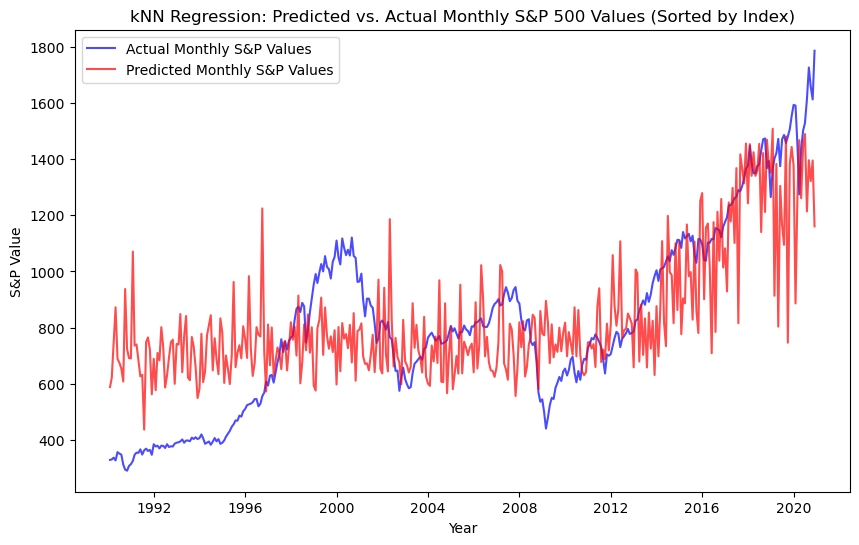

In [42]:
# Sort predictions and actual values
sorted_indices = np.argsort(X_test.index)
sorted_X_test = X_test.iloc[sorted_indices]
sorted_y_test_reg = y_test_reg.iloc[sorted_indices]
sorted_y_test_pred = y_test_pred[sorted_indices]

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(sorted_X_test.index, sorted_y_test_reg, label="Actual Monthly S&P Values", color="blue", alpha=0.7)
plt.plot(sorted_X_test.index, sorted_y_test_pred, label="Predicted Monthly S&P Values", color="red", alpha=0.7)
plt.title("kNN Regression: Predicted vs. Actual Monthly S&P 500 Values (Sorted by Index)")
plt.xlabel("Year")
plt.ylabel("S&P Value")
plt.legend()
plt.show()


Despite using cross-validation to find the kNN model using the number of neighbors, weighting, and distance metric that best fits the data, we find that the kNN model is unfortunately not as strong a model as a basic linear model -- the kNN model with k=10 has an R^2 value of 0.47, while the linear regression we previously modeled had an R^2 value of 0.63.

In [50]:
forest_predictors = ['Admin',
 'Archives',
 'Arts',
 'At Home',
 'Automobiles',
 'Blogs',
 'Books',
 'Booming',
 'Briefing',
 'Burst',
 'Business Day',
 'Climate',
 'College',
 'Corrections',
 "Critic's Choice",
 'Crosswords & Games',
 'Editors Picks',
 'Education',
 'Fashion & Style',
 'Food',
 'Giving',
 'Global Home',
 'Great Homes & Destinations',
 'Guides',
 'Health',
 'Home & Garden',
 'Homepage',
 'Inflation_Adjusted_Close',
 'Inflation_Adjusted_Close_scaled',
 'International Home',
 'Job Market',
 'Lens',
 'Magazine',
 'Movies',
 'Multimedia/Photos',
 'NYT Now',
 'Neediest Cases',
 'New York',
 'Obituaries',
 'Open',
 'Opinion',
 'Parenting',
 'Pct_Change',
 'Pct_Change_scaled',
 'Podcasts',
 'Public Editor',
 'Reader Center',
 'Real Estate',
 'Science',
 'Smarter Living',
 'Sports',
 'Style',
 'Sunday Review',
 'T Brand',
 'T Magazine',
 'Technology',
 'The Learning Network',
 'The Upshot',
 'The Weekly',
 'Theater',
 'Times Insider',
 'Times Topics',
 'Topics',
 'Travel',
 'U.S.',
 'Universal',
 'UrbanEye',
 'Video',
 'Washington',
 'Watching',
 'Week in Review',
 'Well',
 'World',
 'Your Money',
 'membercenter',
 'nationchallenged',
 'none',
 'nytfrontpage',
 'readersopinions',
 'score_textblob_nonzero_scaled',
 'score_textblob_scaled',
 'sentiment_score_VADER_nonzero_scaled',
 'sentiment_score_VADER_scaled',
 'timesselect']


In [51]:
display(monthly_train.columns)

X_train, y_train_reg = monthly_train[forest_predictors], monthly_train['Inflation_Adjusted_Close']
X_test, y_test_reg = monthly_test[forest_predictors], monthly_test['Inflation_Adjusted_Close']
y_train_class = monthly_train['Price_Change_Target']
y_test_class = monthly_test['Price_Change_Target']


Index(['sentiment_score_VADER', 'score_textblob',
       'sentiment_score_VADER_nonzero', 'score_textblob_nonzero',
       'Inflation_Adjusted_Close', 'Pct_Change', 'Admin', 'Archives', 'Arts',
       'At Home', 'Automobiles', 'Blogs', 'Books', 'Booming', 'Briefing',
       'Burst', 'Business Day', 'Climate', 'College', 'Corrections',
       'Critic's Choice', 'Crosswords & Games', 'Editors Picks', 'Education',
       'Fashion & Style', 'Feeds', 'Food', 'Giving', 'Global Home',
       'Great Homes & Destinations', 'Guides', 'Health', 'Home & Garden',
       'Homepage', 'International Home', 'Job Market', 'Lens', 'Magazine',
       'Movies', 'Multimedia/Photos', 'NYT Now', 'Neediest Cases', 'New York',
       'Obituaries', 'Open', 'Opinion', 'Parenting', 'Podcasts',
       'Public Editor', 'Reader Center', 'Real Estate', 'Science',
       'Slideshows', 'Smarter Living', 'Sports', 'Style', 'Sunday Review',
       'T Brand', 'T Magazine', 'Technology', 'The Learning Network',
       'The 

Fitting 5 folds for each of 810 candidates, totalling 4050 fits
Best Parameters: {'ccp_alpha': 0.05, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Accuracy: 0.6091531531531531


/Users/Rohil/micromamba/envs/cs109a/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


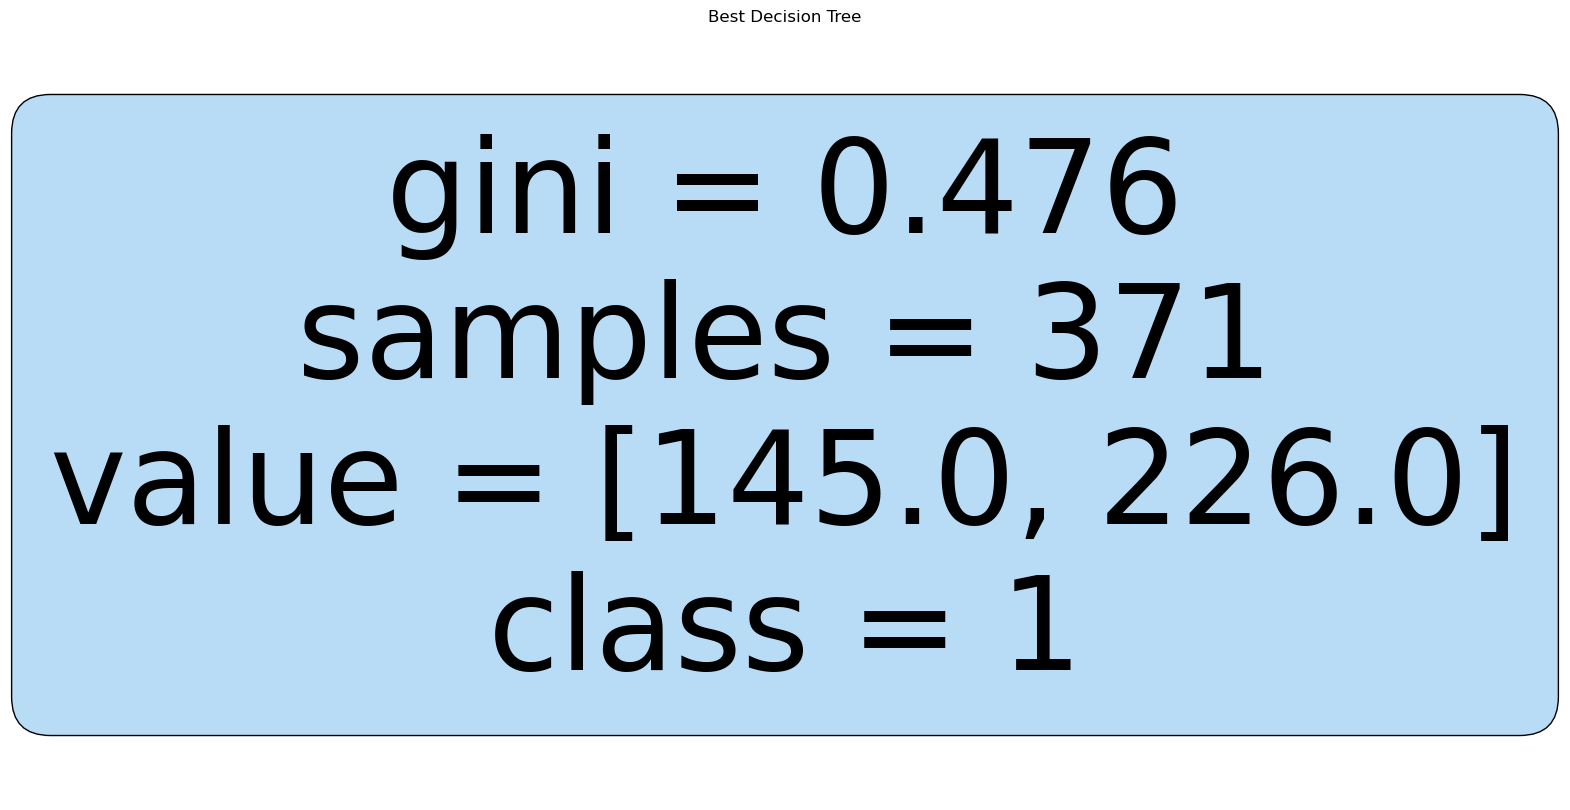

NameError: name 'feature_names' is not defined

In [52]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, cross_val_predict, \
                        GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold

# These are the hyperparameters for this mode
param_grid = {
    'criterion': ['gini', 'entropy'],  # Different criteria to split
    'max_depth': [3, 5, 10, 15, 20],     # depth
    'min_samples_split': [2, 5, 10],      
    'min_samples_leaf': [1, 2, 4],       # leaf size
    'max_features': [None, 'sqrt', 'log2'],     
    'ccp_alpha': [0.0, 0.01, 0.05],       # Pruning
}

# random state we used throughout the notebook
dt_classifier = DecisionTreeClassifier(random_state=42)

# k-fold cross validation
k = 5
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=k, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train_class)

# get best values
best_dt_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

# predict and do Kaggle formatting
y_test_pred = best_dt_model.predict(X_test)
y_test_class


plt.figure(figsize=(20, 10))
plot_tree(
    best_dt_model, 
    feature_names=X_train.columns, 
    class_names=best_dt_model.classes_.astype(str),
    filled=True,
    rounded=True
)
plt.title("Best Decision Tree")
plt.show()


# get feature importance for analysis
feature_importances = best_dt_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]
sorted_features = X_train.columns[indices]
sorted_importances = feature_importances[indices]

# print best features
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print("Feature Importance Table:")
print(feature_importance_df)

# graph n best features
n = 10
plt.figure(figsize=(12, 8))
plt.bar(sorted_features[:n], sorted_importances[:10])
plt.xticks(rotation=45, ha='right')
plt.title(f"Top {n} Feature Gini Importance")
plt.ylabel("Gini Importance (max = 1)")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

# Look at pruning
print("Cost-Complexity Pruning Path:")
ccp_path = best_dt_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = ccp_path.ccp_alphas
impurities = ccp_path.impurities
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas[:-1], impurities[:-1])
plt.title("Cost-Complexity Pruning Path")
plt.xlabel("Alpha")
plt.ylabel("Impurity")
plt.tight_layout()
plt.show()